# Comparing Neural Networks and SVMs for Classification (Hand-drawn Digits)

In this project, I build and compare a number of classification models for a basic classification task: __categorizing hand-drawn digits__. This is one of the most basic "practice" machine learning projects data science practitioners undergo to get practice with all sorts of model types, especially to get exposure to _neural networks_ which is a focus of this project.

In addition to showing the predictive power and scalability of neural network libraries, I also examine this question: can a simpler model perform about as well as, or outperform a neural network for this complex computer vision problem?

## Data, other Technology

The dataset I'm using is the famed [MNIST dataset of hand-drawn digits](https://en.wikipedia.org/wiki/MNIST_database), a collection of around 70,000 images of hand-drawn digits used for training machine learning models. It can be loaded into a development environment straight from scikit-learn's "datasets" repository.

In [1]:
### Packages
# Data manipulation
import random
import numpy as np
import pandas as pd
import scipy.io as scio
%matplotlib inline 
from matplotlib import pyplot as plt
import seaborn as sns
import time

# ML
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC # Linear and 'rbf' kernels in this function
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# DL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

2025-02-06 23:04:32.276183: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
### Data
mnist = fetch_openml('mnist_784', version = 1, as_frame = False, parser = 'auto')
X, y = mnist['data'], mnist['target']

In this version of the dataset, images are stored in a relational dataframe where each row is one image and the "features" of the images are the pixel values -- each image having 784 pixels in total. I do some basic data pre-processing below to account for the need for normalized feature values in the machine learning models I'll be using, as well as the fact that the label values are currently strings:

In [3]:
# Normalize features (pixels)
X = X / X.max()

# Label encode y values
label_encoder = LabelEncoder()
label_encoder.fit(y)
y_encoded = label_encoder.transform(y)

NOTE: I am not certain that the testing data is in fact the data starting at index 60,000 but I used that split as an effective "train-test split" index anyway. The images are all sufficiently similar that any subset of the data is equally viable for testing as any other.

In [4]:
# Splitting
x_train = X[0:60000, ]
x_test = X[60000:, ]
y_train = y_encoded[0:60000]
y_test = y_encoded[60000:]

Though the datapoints are stored as rows with the pixels as features, it's possible to get a look at them with pyplot. Here's what the first training set image looks like:

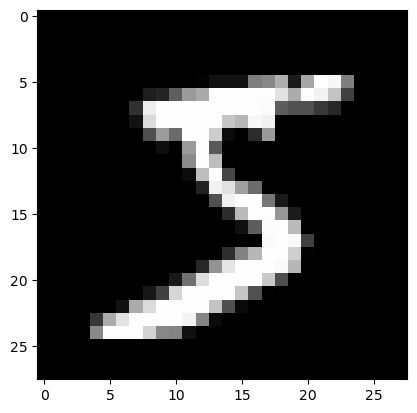

In [29]:
# Test image
img_test = np.array(x_train[0]).reshape(28, 28)

plt.imshow(img_test, cmap = 'gray')
plt.show()

And here is the label of the same datapoint:

In [6]:
y_train[0]

5

Must humans can look at this image and can say pretty confidently that it is the number five. Though it's not a surprising fact, it still is pretty remarkable when you think about it.

It's even more remarkable when considering that this kind of problem could likely stump very complex machine learning methods. This is one of the things that make this problem so enticing for enthusiasts of machine learning and even artificial intelligence: there is some innate feature of human cognition that makes a task like this extremely simple for a human but highly complex for an automated algorithm.

## Neural Network Model

The first and most important approach I'll take to this data is a _neural network_ model. These are really complex algorithms, but suffice it to say neural networks take granular data, feed them through multiple layers of densely connected "perceptrons", and find a high number of parameters that represent multiple interdependencies and relationships in the data between features.

So, if some data had a sizeable number of features, and the conditional values and relationships between features in particular were key determinants in whether the data were or were not positive instances of a class, a neural network may be especially well-suited to that kind of problem.

That's why this dataset is so popular for learning about and training neural networks. Several numerals from 0 to 9 have lots of the same abstract visual features: straight lines, open loops, closed loops, intersecting lines, and so on. A neural network trained on a sufficient amount of these images might be able to learn, as well as a human, how various visual features in various places on an image impact a probability that an image is one number or another.

For a very basic overview of how neural networks work, check out [this YouTube video by 3 Blue; 1 Brown](https://youtu.be/aircAruvnKk?si=YG-jvajk_qGXdObA).

Here is a basic neural network model setup using the Tensorflow and Keras packages:

In [7]:
### Models First pass
## Neural Network Classifier (Keras)
keras_nnet = keras.Sequential([
    layers.Input(shape = (784, )),  # Input layer
    layers.Dense(128, activation = 'relu'),  # First hidden layer
    layers.Dense(64, activation = 'relu'),  # Second hidden layer
    layers.Dense(10, activation = 'softmax')  # Output layer
])

# Compile the model
keras_nnet.compile(optimizer = 'adam',
                   loss = 'sparse_categorical_crossentropy',
                   metrics = ['accuracy'])

To break this code down a little bit:

* the "Sequential" class is used for ease of specifying each "layer" in the network, one-by-one, with its specific features

* I add an input layer that is programmed to expect data with 784 input features (one per pixel)

* I add two "densely" connected hidden layers, each with a linear activation function (some other popular activation functions include _sigmoid_ and _hyperbolic tangent_)

* The output layer has 10 output nodes and has a "softmax" activation function, an activation function suited to classification.

And here's a summary of the model setup:

In [8]:
# Print the model summary
keras_nnet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

This illustrates the complexity of these models in practical terms: this model has over __100,000 total parameters__, whereas a basic linear regression model may have a number of features in the mid-double digits.

Next, I fit the model and make predictions:

In [9]:
# Fitting model
keras_nnet.fit(x_train, y_train, epochs = 10, batch_size = 256)

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7796 - loss: 0.7999
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9505 - loss: 0.1719
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9661 - loss: 0.1189
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9741 - loss: 0.0875
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9794 - loss: 0.0711
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9819 - loss: 0.0610
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9858 - loss: 0.0492
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9892 - loss: 0.0392
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9910 - loss: 0.0327
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9927 - loss: 0.0273


In [10]:
# Making predictions
predictions_keras_nnet = keras_nnet.predict(x_test)
predictions_keras_nnet = predictions_keras_nnet.argmax(axis = 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [11]:
# Accuracy
accuracy_score(y_test, predictions_keras_nnet)

0.9761

This neural network model achieved a dazzling testing accuracy of 97.6% (the highest training accuracy it achieved was 99%). Assuming a human could look at any hand-drawn digit and readily identify it, it could be said that this model is able to replicate human-level intelligence with 97.6% accuracy. With a theoretically complex setup that is admittedly very easy to code, this model can tell the difference between several different digits drawn by different humans which is very impressive.

Was the model especially more prone to confusing some numbers with others? Let's find out:

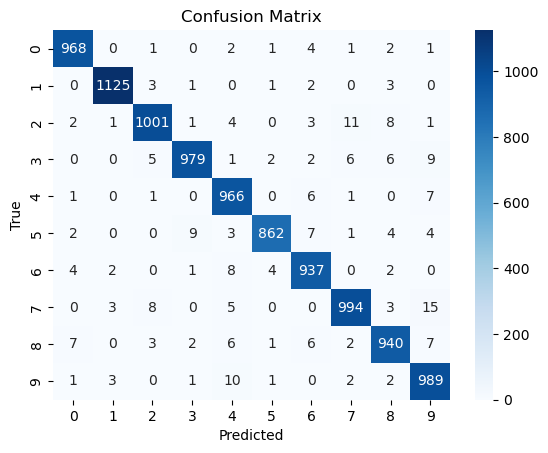

In [12]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions_keras_nnet)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

With the rate of false negatives or false positives to accurate guesses so low, it's hard to make out any noticeable patterns. But it does look like the model confused a higher number of "7"s for "2"s, "9"s for "7s", and "4"s for "9"s.

In [13]:
# Other heuristics
print('Model precision: {}'.format(round(precision_score(y_test, predictions_keras_nnet, average = 'macro'), 3)))
print('Model recall: {}'.format(round(recall_score(y_test, predictions_keras_nnet, average = 'macro'), 3)))
print('Model F1 score: {}'.format(round(f1_score(y_test, predictions_keras_nnet, average = 'macro'), 3)))

Model precision: 0.976
Model recall: 0.976
Model F1 score: 0.976


Tensorflow and Keras are some of the most popular open source Python packages for implementing deep learning algorithms -- another being PyTorch. While Tensorflow and Keras allow for a high level of customizeability and specification in the setups of neural network models and the kinds that users can create, they do abstract away important specifications about neural networks. Those are specifications that PyTorch does allow users to control, but it is more complex to use coding-wise.

Though it's very simplistic, scikit-learn also has its own ready-made implementations of basic neural network algorithms, including a basic feed-forward neural network. Here is how that model, called "MLPClassifier" with much the same specifications does on the same data:

In [14]:
## SKLearn Multi-layer Perceptron Model
# Create model, fit
sklearn_nnet = MLPClassifier(hidden_layer_sizes = (128, 64), max_iter = 200, random_state = 1)
sklearn_nnet.fit(x_train, y_train)

MLPClassifier(hidden_layer_sizes=(128, 64), random_state=1)

In [15]:
# Results
predictions_sklearn_nnet = sklearn_nnet.predict(x_test)
accuracy_score(y_test, predictions_sklearn_nnet)

0.9822

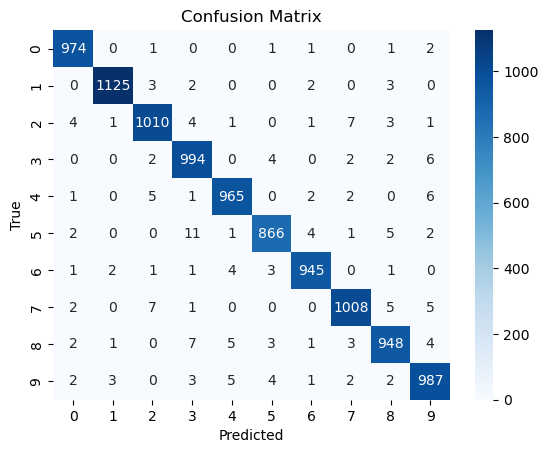

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions_sklearn_nnet)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [17]:
# Other heuristics
print('Model precision: {}'.format(round(precision_score(y_test, predictions_sklearn_nnet, average = 'macro'), 3)))
print('Model recall: {}'.format(round(recall_score(y_test, predictions_sklearn_nnet, average = 'macro'), 3)))
print('Model F1 score: {}'.format(round(f1_score(y_test, predictions_sklearn_nnet, average = 'macro'), 3)))

Model precision: 0.982
Model recall: 0.982
Model F1 score: 0.982


It performed almost identically. Though you can see that the scikit-learn model's accuracy was slightly higher, what you can't see is that training and using that model took several minutes, whereas the Keras model could be trained and used in less than 30 seconds, something I analyze in further detail later.

### Can a Support Vector Machine Beat a Neural Network?

In addition to doing this project to build a basic neural network, I also want to try and replicate a curious result I came across once in school: in this particular problem, a very simple model like a Support Vector Machine (SVM) can perform relatively well, almost as well as a neural network.

It's very confusing that this would conceptually be the case. One supposed advantage of neural networks would have in a problem like this is learning complex relationships within the data in order to achieve higher prediction accuracy. It's hard to think that a linear model could attain the same accuracy with far fewer parameters. But let's dive in and see what happens!

First, while I am a vocal proponent of simpler models, it's clear that if this model is trained on the entirety of the training data, training could take several hours. So I implement a neat trick I learned for this model especially and downsample the data so only a subset of it is used in training. This saves on time, though it could possibly affect accuracy.

In [18]:
### Support Vector Classifier
# Downsample data
ds_ids = random.sample(range(0, 60000), 10000)
xtrain_ds = x_train[ds_ids]
ytrain_ds = y_train[ds_ids]

In [19]:
# Create model, fit
sv_model = SVC(kernel = 'linear', random_state = 1)
sv_model.fit(xtrain_ds, ytrain_ds)

SVC(kernel='linear', random_state=1)

In [20]:
# Results
predictions_sv = sv_model.predict(x_test)
accuracy_score(y_test, predictions_sv)

0.919

Note that the SVM model achieved a 92% testing accuracy. This feels to me like finding some problem where a linear regression model could perform only 6 percentage points worse than a multi-layer neural network model. This was when I first saw it, and still remains a fascinating result to me.

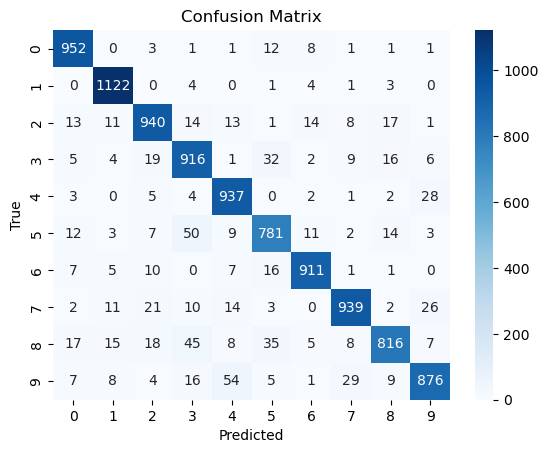

In [21]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions_sv)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Other heuristics
print('Model precision: {}'.format(round(precision_score(y_test, predictions_sv, average = 'macro'), 3)))
print('Model recall: {}'.format(round(recall_score(y_test, predictions_sv, average = 'macro'), 3)))
print('Model F1 score: {}'.format(round(f1_score(y_test, predictions_sv, average = 'macro'), 3)))

Model precision: 0.919
Model recall: 0.918
Model F1 score: 0.918


I have thought for some time about why a SVM model might perform about as well as a neural network, and it still baffles me. One thing SVM algorithms are good for is modeling high-dimensional data, and these images definitely have a high number of dimensions. However, it is hard to imagine that a linear model like this could achieve the same level of performance of a neural network on more complex computer vision tasks, like image recognition with a high number of potential classes, or facial recognition.

Instead of approaching the result with priors and then trying to validate them, this result could also lead to some deduction about an aspect of the problem. It could be that the non-linear, higher-order relationships between features and conditional feature values just don't matter, and that the data, mapped in a high dimensional space, really is linearly separable, or mostly so.

Though a 6-percentage point deficit seems small in absolute terms, this particular problem could full well warrant a disqualification, or a barring of consideration for this model. 92% accuracy seems high, but would humans actually tolerate any automation process to read hand-drawn digits which had a 1 in 10 chance of incorrectly reading a number? In this context, even a 92% accuracy is likely not high enough to consider a model for production, no matter its benefits.

### Further Model Evaluation: Neural Networks with Downsampled Data

Since the SVM model used downsampled data, I likewise wanted to see how the neural network models perform with the same dataset:

In [24]:
### Retrying with downsampled data
## Keras Neural Net Retry
keras_nnet.fit(xtrain_ds, ytrain_ds, epochs = 10, batch_size = 256)
predictions_keras_nnet = keras_nnet.predict(x_test)
predictions_keras_nnet = predictions_keras_nnet.argmax(axis = 1)
accuracy_score(y_test, predictions_keras_nnet)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9998 - loss: 0.0024
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0021
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0019
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0016
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 9/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 10/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


0.9779

In [25]:
## SKLearn Neural Net Retry
sklearn_nnet.fit(xtrain_ds, ytrain_ds)
predictions_sklearn_nnet = sklearn_nnet.predict(x_test)
accuracy_score(y_test, predictions_sklearn_nnet)

0.9601

Both models performed essentially just as well as the did with the full dataset. Neural networks benefit from large amounts of training data, but it seems for this particular problem and dataset, high accuracy can be achieved with a very low amount of training data.

### Further Model Evaluation: Efficiency

Last, I analyze which of all the models can be run the quickest:

In [26]:
### Retrying all to check efficiency
## Keras Neural Net; Full Dataset - Timed Test
start = time.time()

keras_nnet.fit(x_train, y_train, epochs = 10, batch_size = 256)
predictions_keras_nnet = keras_nnet.predict(x_test)
predictions_keras_nnet = predictions_keras_nnet.argmax(axis = 1)
print('Model accuracy: {}'.format(round(accuracy_score(y_test, predictions_keras_nnet), 3)))

print('Time elapsed: {} seconds'.format(round(time.time() - start, 2)))

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9902 - loss: 0.0317
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9926 - loss: 0.0237
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9952 - loss: 0.0161
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9966 - loss: 0.0124
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9977 - loss: 0.0097
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9975 - loss: 0.0089
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9986 - loss: 0.0064
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9989 - loss: 0.0055
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9969 - loss: 0.0108
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9987 - loss: 0.0050
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model accuracy: 0.978
Time elapsed: 16.62 seconds


In [27]:
## SKLearn Neural Net; Full Dataset - Timed Test
start = time.time()

sklearn_nnet.fit(x_train, y_train)
predictions_sklearn_nnet = sklearn_nnet.predict(x_test)
print('Model accuracy: {}'.format(round(accuracy_score(y_test, predictions_sklearn_nnet), 3)))

print('Time elapsed: {} seconds'.format(round(time.time() - start, 2)))

Model accuracy: 0.982
Time elapsed: 133.33 seconds


In [28]:
## SVM; Downsampled Data - Timed Test
start = time.time()

sv_model.fit(xtrain_ds, ytrain_ds)
predictions_sv = sv_model.predict(x_test)
print('Model accuracy: {}'.format(round(accuracy_score(y_test, predictions_sv), 3)))

print('Time elapsed: {} seconds'.format(round(time.time() - start, 2)))

Model accuracy: 0.919
Time elapsed: 25.01 seconds


So, the analysis of efficiency rounds out this picture of the model strengths and weaknesses. The neural network models are highly accurate, and the Keras model in particular can be run extraordinarily fast. The scikit-learn neural network model is likewise highly accurate, but takes nearly 10x the amount of time to train and to make predictions. Lastly, the SVM is relatively efficient, at least compared to the scikit-learn neural network model, but its accuracy is noticeably lower than that of the neural network models.